## Processing Faces

In [61]:
# import the necessary packages
%matplotlib inline
import imutils
from imutils import face_utils
import dlib
import cv2
from cv2 import imshow as cv2_imshow
from cv2 import rectangle
import math
import matplotlib.pyplot as plt
import numpy as np
from imutils.video import VideoStream

import face_recognition
from skimage.feature import hog
from skimage import exposure

### Helper functions

In [2]:
def plotpic(image, title,fig=(8,8),axis='off'):
    plt.figure(figsize=fig)
    plt.title(title)
    plt.axis(axis)
    if len(image.shape) < 3:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
    plt.show()  # display it
    
    
def create_HOG_image(image):
    #fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=True)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)


    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_image_rescaled

#PyImageSearch Implementation
def HOG_image2(image):
    (H, hogImage) = hog(image, orientations=9, pixels_per_cell=(10, 10),cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    return hogImage

def center_poly(points):
    x = y = 0
    for i in range(len(points)):
        x = x + points[i][0]
        y = y + points[i][1]
    x = x//len(points)
    y = y//len(points)
    return(x,y)

def eyeline(image,landmark,width=2, color=(255,0,0)):
    if len(landmark) != 2: return
    pt0 = center_poly(face_landmarks[landmark[0]])
    pt1 = center_poly(face_landmarks[landmark[1]])
    cv2.line(image,pt0,pt1,color,width)
    
def eyedot(image, landmark,rad =5,color=(255,0,0)):
    points = face_landmarks[landmark]
    cv2.circle(image,center_poly(points),rad,color,-1)
    
def tiltangle(landmark):
    #by convention right eye minus left eye
    if len(landmark) != 2: return
    pt0 = center_poly(face_landmarks[landmark[0]])
    pt1 = center_poly(face_landmarks[landmark[1]])
    
    dx = pt1[0] - pt0[0]
    dy = pt1[1] - pt0[1]
    angle = np.degrees(np.arctan2(dy, dx)) 
    #print(pt1[0],pt0[0],dx)
    #print(pt1[1], pt0[1],dy)
    return angle


## Select a face to load

In [45]:
#face_img = cv2.imread('images/memes/And-Just-Like-That.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/lena.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Misunderstood-Mitch.jpg', cv2.IMREAD_COLOR)
face_img = cv2.imread('images/memes/Tom-Hanks.jpg', cv2.IMREAD_COLOR)
face_img = cv2.imread('images/memes/Tom-Hanks.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Disappointed-Tyson.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Success-Kid.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Han-Solo.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Creepy-Condescending-Wonka.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/tom hanks roles.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/johnnyDepp.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Steve-Jobs.jpg', cv2.IMREAD_COLOR)
#face_img = cv2.imread('images/memes/Sparta-Leonidas.jpg', cv2.IMREAD_COLOR)


In [46]:
type(face_img), face_img.shape

(numpy.ndarray, (177, 284, 3))

### Show the image

We are using MatPlotLib to show images because it plays nicer than cv2 with jupyter

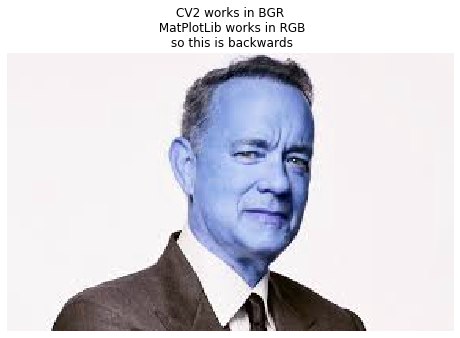

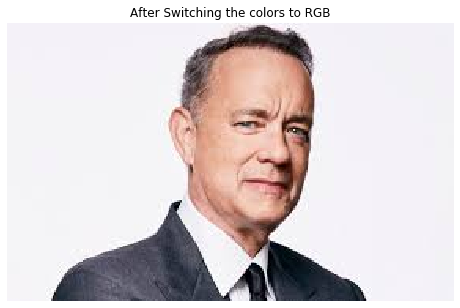

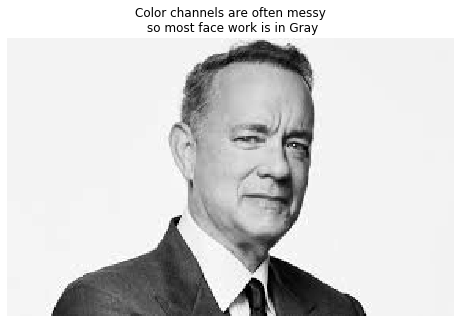

In [47]:
face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
face_gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
face_raw = face_rgb.copy()
plotpic(face_img,'CV2 works in BGR\n MatPlotLib works in RGB\n so this is backwards')
plotpic(face_rgb,'After Switching the colors to RGB')

plotpic(face_gray,'Color channels are often messy\n so most face work is in Gray' )



## Face Detection
first find the faces using Histogram of Oriented Gradients (HOG).  HOG is a map of how brightness chasnges over the image

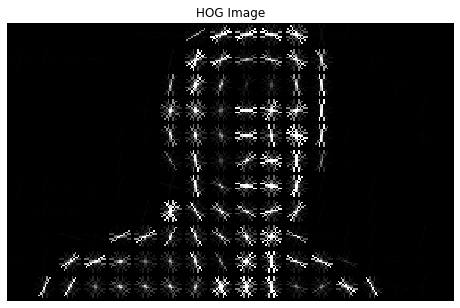

In [48]:
hog_image = create_HOG_image(face_gray)
plotpic(hog_image,'HOG Image')


Notice that the eyes are distinctive, the gradients change rapidly there

They are, however, not dispositive

### Find locations on the face.
We are using the library Face Recognition `https://github.com/ageitgey/face_recognition` This library makes use of dlib and provides several conveniance functions

face_locations finds all of the faces in the image

In [49]:
face_locations = face_recognition.face_locations(face_gray)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

I found 1 face(s) in this photograph.


### Extract the faces and circle them

A face is located at pixel location Top: 36, Left: 126, Bottom: 126, Right: 215


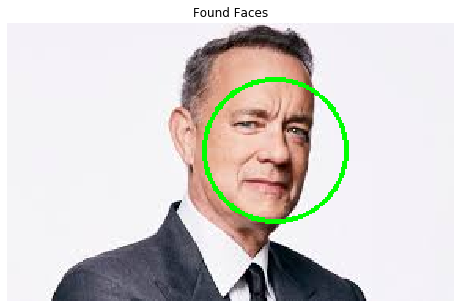

In [50]:
for face_location in face_locations:
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    
    #cv2.rectangle(face_rgb, (left,top), (right,bottom), (0, 255, 0), 2);
    center = ((right +left)//2, (bottom + top)//2)
    radius = right - (right + left) //2
    cv2.circle(face_rgb,center,radius,(0, 255, 0),2)
    
        
plotpic(face_rgb,'Found Faces' )


### Find Face Landmarks
Face_landmarks_list is a list of all of the face landmarks for all of the faces found.  They contain:
- chin,
- left_eyebrow, 
- right_eyebrow, 
- nose_bridge, 
- nose_tip, 
- left_eye, 
- right_eye, 
- top_lip, 
- bottom_lip

We will mark the center of the eyes for each face and draw the line connecting them

In [51]:
face_landmarks_list = face_recognition.face_landmarks(face_gray)
#print(face_landmarks_list)
#face_keys = face_landmarks_list[0]
#
#print (face_landmarks_list[0].keys())

### Find the eyes and the line connecting them

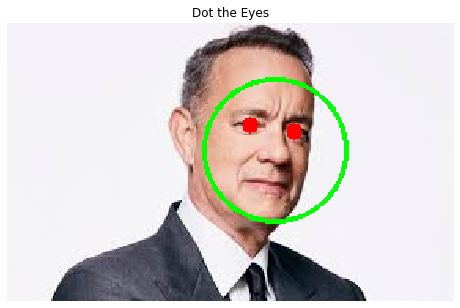

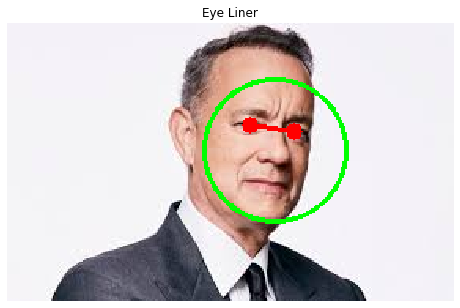

In [52]:
eyes =['left_eye', 'right_eye']
for face_landmarks in face_landmarks_list:
    for e in eyes:
        eyedot(face_rgb,e)
    plotpic(face_rgb,'Dot the Eyes' )
    eyeline(face_rgb,eyes)
    plotpic(face_rgb,'Eye Liner' ) 
    #print (tiltangle(eyes))

### By untilting the face, making the eyes level, we reduce the complexity of face identifcation

Here we use the cv2.warpAffine method

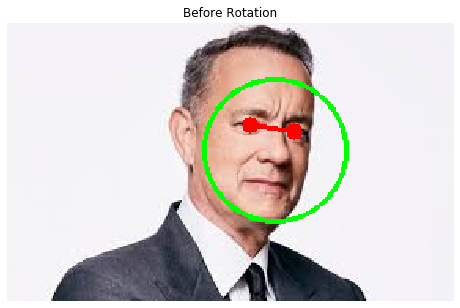

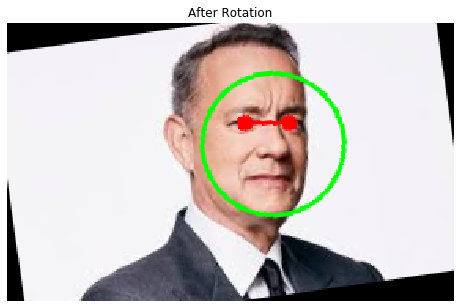

In [53]:
#copy the face
facework = face_rgb.copy()
rows,cols = facework.shape[:2]
M = cv2.getRotationMatrix2D((cols/2, rows/2), tiltangle(eyes), 1)
face_rot = cv2.warpAffine(facework,M, (cols,rows))
plotpic(facework,'Before Rotation' )     
plotpic(face_rot,'After Rotation')

### Extract the untilted face and normalize it for face recognition

Here we use the imutils rotate method, which is much easier

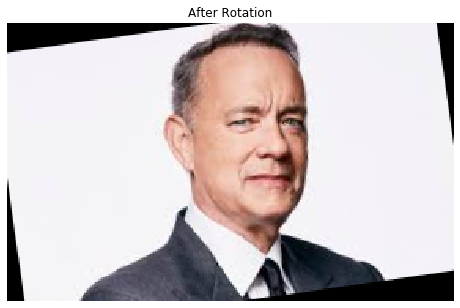

In [54]:
#desired width is 265 
width = 256
rot_face_raw= imutils.rotate(face_raw, angle=tiltangle(eyes))
plotpic(rot_face_raw,'After Rotation')

### We don't have an identified face on this image, so we will find it again

I found 1 face(s) in this photograph.


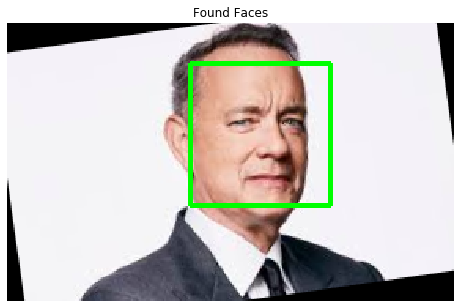

In [55]:
rot_face_working = rot_face_raw.copy()
face_locations = face_recognition.face_locations(rot_face_working)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:
    top, right, bottom, left = face_location 
    cv2.rectangle(rot_face_working, (left,top), (right,bottom), (0, 255, 0), 2);
    
plotpic(rot_face_working,'Found Faces') 

### We want the faces to have a width of 256, so we have to resize them  also face_recognition tends to cut off the forehead and chin, 
- first pad them down to the maximum of the chin (points 0-17)
- then we will crop the face 10% biger
- then resize, keeping aspect ratio, to a horozontal size of 256

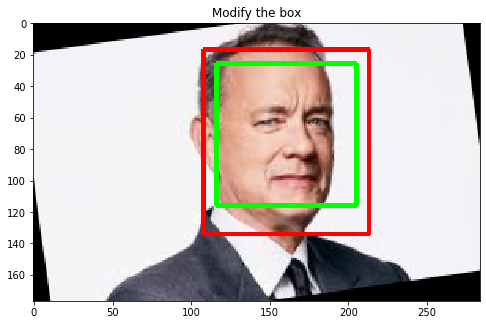

In [56]:
#desired width is 265 
width = 256


fll = face_recognition.face_landmarks(rot_face_raw)

#fll is a list of dictionaries, with an entry for easch face
max = 0
for i in range(len(fll[0]['chin'])):  #there are 17 points
    col,row = fll[0]['chin'][i]
    #print (col,row)
    if row > max: max = row

hpad = math.ceil((right - left)//10)
vpad = math.ceil((max-top)//10)
#print (left,top,right,max)
#print (left-hpad,top-vpad,right+hpad,max+vpad)
x1 = left-hpad
x2 = right+hpad
y1 = top-vpad
y2 = max + vpad
cv2.rectangle(rot_face_working, (x1,y1), (x2,y2), (255, 0, 0), 2);
plotpic(rot_face_working,'Modify the box',axis='on') 


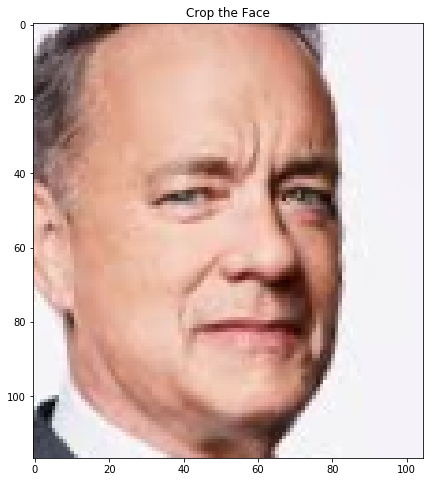

In [57]:
crop_face = rot_face_raw[y1:y2,x1:x2]
plotpic(crop_face,'Crop the Face',axis='on') 

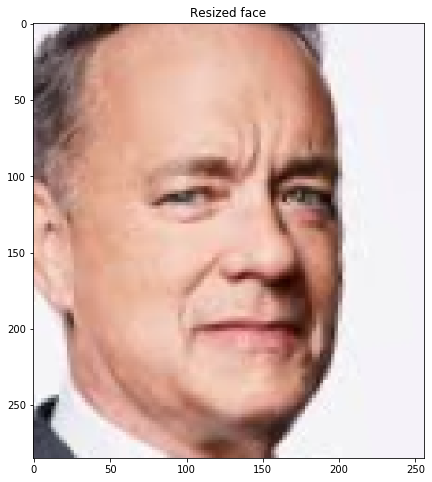

In [58]:
resized_face = imutils.resize(crop_face, width=width)
plotpic(resized_face,'Resized face',axis='on')

In [59]:
#we have been working in BGR colorspace so we need to revert to save the image

cv2.imwrite('images/resizedmemes/hansolo.jpg',cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))

True

In [60]:
rgb_encoding = face_recognition.face_encodings(cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))
bgr_encoding = face_recognition.face_encodings(resized_face)
for i in range (len(rgb_encoding)):
    print (rgb_encoding[i] - bgr_encoding[i])

[-1.35899484e-02  3.16198319e-02 -9.80376638e-03  3.11135631e-02
  5.34369983e-03  2.48271655e-02 -3.32296360e-02 -1.53794885e-02
 -2.85981596e-03 -4.44868393e-02  2.29474902e-03 -3.63929737e-02
 -5.04457951e-03 -1.88633986e-02  2.34197797e-02  1.51441693e-02
  3.89473140e-03  1.70094371e-02 -1.34131238e-02 -9.22851264e-04
  7.10850302e-03  3.64225358e-03  8.99808668e-03 -1.58137791e-02
  2.54907683e-02 -1.36260092e-02  1.93298981e-02  7.43448734e-04
  2.80519947e-03 -1.31788664e-02 -3.97686698e-02 -6.46064430e-03
  8.84375721e-03 -2.93637626e-03 -1.82036683e-02 -3.87143157e-03
  7.28365034e-03  1.21399481e-02  2.93064117e-03 -4.50830311e-02
 -1.87850744e-02  1.42622739e-04  1.24396719e-02 -3.35409343e-02
 -5.85293770e-03  2.23654881e-03 -2.88504288e-02 -3.07722390e-03
  8.79675150e-03  1.64677501e-02 -2.79423594e-02  1.25513524e-02
  5.35303354e-03  1.46206915e-02 -1.04434192e-02  1.77269727e-02
 -1.97414681e-02  1.13315657e-02  2.06598490e-02 -3.05192620e-02
  1.75868049e-02  1.02560